# A1: Recommender Systems (part 1)#

Marija Trajanoska (marijatrajanoska@gmail.com) and Joshiwa van Marrewijk (joshiwa01@gmail.com) [Group 72]

The purpose of this project is to utilize the 1M Movielens data set to build a recommandation system for movies. This notebook is part 1 of 2. In this part we implement four naïve models as benchmarks. The goal is to create a baseline for the more advanced approach, which will be presented in part 2. We compute the strength of the benchmark by calculating the Root Mean Square Error (RMSE) between the true ratings and predictions. We further apply 5-fold cross-validation to get a realistic estimate of the performance and stabillity of the model when applied to unknown data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
sb.set_context('notebook')

In [2]:
# load data
ratings = np.genfromtxt("ratings.dat", usecols=(0, 1, 2), delimiter='::', dtype='int')

## The Naïve Models ##
We used four basic recommender systems, listed in order starting from most basic to more complex.

1. ***Global mean***: we compute the global mean of all the ratings in the data set and use it as a predicted value for all ratings. 

$$R_{global} = mean(\text{all ratings}) $$

In [3]:
def calculate_ratings_global_mean(train, test):
    R_global = np.mean(train[:,2])
    train_diff = train[:,2]-R_global
    test_diff = test[:,2]-R_global
    return R_global, train_diff, test_diff

2. ***Average rating per user***: we compute the mean rating per user and use it as a predicted rating for that user. Users which are in the test set but not in the training set get the global mean as a predicted rating.

$$R_{user} = mean(\text{all ratings for user i}) $$

In [4]:
def calculate_ratings_user_mean(train, test):
    df_train = pd.DataFrame(train)
    df_test = pd.DataFrame(test)
    df_train.set_index(0, inplace=True) 
    df_test.set_index(0, inplace=True) 
    
    R_user_train = df_train.groupby(df_train.index)[2].mean() 
    
    train_diff = df_train[2].sub(R_user_train) 
    test_diff = df_test[2].sub(R_user_train, fill_value=R_global)
    
    return R_user_train, train_diff, test_diff

3. ***Average rating per item***: we compute the mean rating per item and use it as a predicted rating for that item. Items which are in the test set but not in the training set get the global mean as a predicted rating.

$$R_{item} = mean(\text{all ratings for item j}) $$

In [5]:
def calculate_ratings_item_mean(train, test):
    df_train = pd.DataFrame(train)
    df_test = pd.DataFrame(test)    
    df_train.set_index(1, inplace=True)
    df_test.set_index(1, inplace=True)
    
    R_item_train = df_train.groupby(df_train.index, as_index=True)[2].mean() 
    
    train_diff = df_train[2].sub(R_item_train)
    test_diff = df_test[2].sub(R_item_train, fill_value=R_global)

    return R_item_train, train_diff, test_diff

4. ***A linear combination of the above***: we computed a linear combination of a vector containing the average rating per user and a vector containing the average rating per item. The coefficients for the linear regression are determined by a least square estimator (lsq). The coefficients for $\alpha, \beta \ \text{and} \ \gamma$ that will be shown further on. To apply the lsq we used the _numpy_ package np.linalg.lstsq(). This is described as follows:

$$R_{user-item} = \alpha R_{user} + \beta R_{item} + \gamma$$

In [6]:
def calculate_ratings_linear_regression(train, test, R_user_mean, R_item_mean):
    df_train = pd.DataFrame(train)
    df_test = pd.DataFrame(test)
    df_user_mean = pd.DataFrame(R_user_mean)
    df_item_mean = pd.DataFrame(R_item_mean)
    df_user_mean.reset_index(inplace=True, drop=False)
    df_item_mean.reset_index(inplace=True, drop=False)
    
    df_train = df_train.reset_index().merge(df_item_mean, on=1, how='left',sort=False).sort_values('index')
    df_train = df_train.reset_index().merge(df_user_mean, on=0, how='left',sort=False).sort_values('index')
    df_matrix = pd.concat([df_train[2], df_train['2_y']], axis=1)    
    
    input_matrix = df_matrix.values
    ones = np.ones((input_matrix.shape[0],1))
    input_matrix = np.hstack((input_matrix,ones))
    alpha, beta, gamma =  np.linalg.lstsq(input_matrix,train[:,2],rcond=None)[0] 
    
    df_test = df_test.merge(df_item_mean, on=[1])
    df_test = df_test.merge(df_user_mean, on=[0])    
    df_test_matrix = pd.concat([df_test[2], df_test['2_y']], axis=1)    
    test_matrix = df_test_matrix.values
    
    ratings_train = alpha*input_matrix[:,0] + beta*input_matrix[:,1] + gamma   
    ratings_test = alpha*test_matrix[:,0] + beta*test_matrix[:,1] + gamma 
    
    train_diff = df_train['2_x'] - ratings_train
    test_diff = df_test['2_x'] - ratings_test
    
    return alpha, beta, gamma, train_diff, test_diff

### Error metric ###
To determine the effectiveness of the recommendations systems we determined the RMSE of the predicted versus the true ratings. The RMSE is defined as follows. $$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{(predicted - true)^2}}$$ 
The difference between the true and predicted rating
is squared since it can be either positive or negative. We sum across all the users and all the items, and divide by the number of ratings. The interpretation of the RMSE is as follows: a value of 1 means that the recommendation system is, on average, 1 star off the true rating. A lower value for RMSE is better. For context, the 1 million dollar Netflix prize was awarded for a
RMSE of approximately 0.85.

The following function computes the RMSE given an array of differences between true and predicted ratings.

In [7]:
def RMSE_from_difference(diff):
    return np.sqrt(np.mean((diff)**2))

### Cross-validation ###
For cross-validation, we split the data into five equally sized sections (folds) and divided the data in train and test sets, such that each time four folds belong to the training set, and the remaining fold constitutes the test set. We train the model on the training set and then test it on the test set. We determine the predicted ratings on each training and test set and compute the RMSE for each split of the data set. The final RMSE per model is determined by taking the average RMSE over all 5 folds per train and test data. The standard deviation over these 5 trials gives insight into the stability of the model. A small standard deviation describes a low variation over the RMSE and thus suggests that the model is stable. 

In [8]:
# define number of folds for cross validation
nfolds=5

# to make sure we are able to repeat the results, we set the random seed to something
np.random.seed(17)

# we shuffle the dataframe
seqs = [x%nfolds for x in range(len(ratings))]
np.random.shuffle(seqs)

# allocate memory for results
rms_train_global=np.zeros(nfolds)
rms_test_global=np.zeros(nfolds)
rms_train_user=np.zeros(nfolds)
rms_test_user=np.zeros(nfolds)
rms_train_item=np.zeros(nfolds)
rms_test_item=np.zeros(nfolds)
rms_train_lsq=np.zeros(nfolds)
rms_test_lsq=np.zeros(nfolds)
param1=np.zeros(nfolds)
param2=np.zeros(nfolds)
param3=np.zeros(nfolds)

# loop over folds
for fold in range(nfolds):
    
    train_sel=np.array([x!=fold for x in seqs])
    test_sel=np.array([x==fold for x in seqs])
    train=ratings[train_sel]
    test=ratings[test_sel]
    
    # global mean
    R_global, train_diff, test_diff = calculate_ratings_global_mean(train, test)
    rms_train_global[fold] = RMSE_from_difference(train_diff)
    rms_test_global[fold] = RMSE_from_difference(test_diff)
    
    #user mean
    R_user_mean, train_diff, test_diff = calculate_ratings_user_mean(train, test)
    rms_train_user[fold]= RMSE_from_difference(train_diff)
    rms_test_user[fold]= RMSE_from_difference(test_diff)
    
    #item mean      
    R_item_mean, train_diff, test_diff = calculate_ratings_item_mean(train, test)
    rms_train_item[fold]= RMSE_from_difference(train_diff)
    rms_test_item[fold]= RMSE_from_difference(test_diff)
    
    #linear regression
    alpha, beta, gamma, train_diff, test_diff = calculate_ratings_linear_regression(train, test, R_user_mean, R_item_mean)
    
    rms_train_lsq[fold]= RMSE_from_difference(train_diff)
    rms_test_lsq[fold]= RMSE_from_difference(test_diff)
    
    # save lstsq regression parameters for this fold
    param1[fold] = alpha
    param2[fold] = beta
    param3[fold] = gamma

# Visualisation of the results #

We plotted the RMSE for every fold in the cross-validation below. Underneath the plots we showed the average RMSE per train and test data set with their corresponding standard deviation. Finally we showed the parameters used for the linear regression, with their standard deviations below. These parameters are averaged over each fold. 

The two functions below are used to visualize the results.

In [9]:
def nice_print(train, test, types):
    print("=========================================================================")
    print('{} {:04.3f} {} {:04.3f}'.format("Mean error on " + types + " train data: ", np.mean(train), 'with a std on the error of:', np.std(train)))
    print('{} {:04.3f} {} {:04.3f}'.format("Mean error on " + types + " test data: ", np.mean(test), 'with a std on the error of:', np.std(test)))
    print("=========================================================================")
    
def nice_plot(title,train,test):
    plt.figure()
    plt.title(title)
    plt.plot(range(0,nfolds,1), train, label ='train data')
    plt.plot(range(0,nfolds,1), test, label = 'test data')
    plt.xlabel('folds')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()

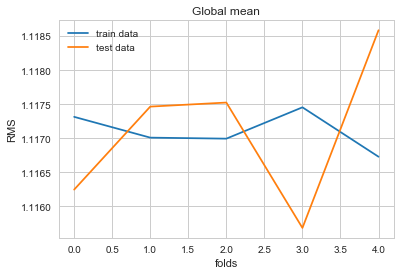

Mean error on global train data:  1.117 with a std on the error of: 0.000
Mean error on global test data:  1.117 with a std on the error of: 0.001


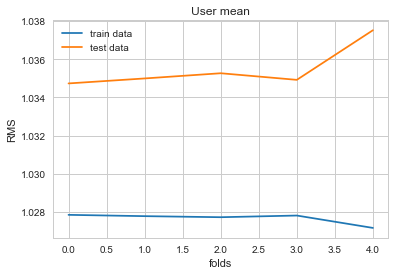

Mean error on user train data:  1.028 with a std on the error of: 0.000
Mean error on user test data:  1.035 with a std on the error of: 0.001


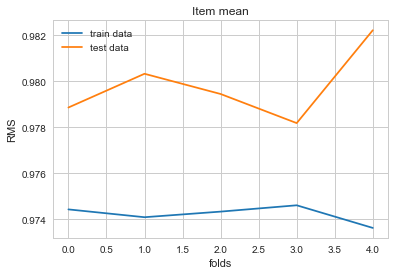

Mean error on item train data:  0.974 with a std on the error of: 0.000
Mean error on item test data:  0.980 with a std on the error of: 0.001


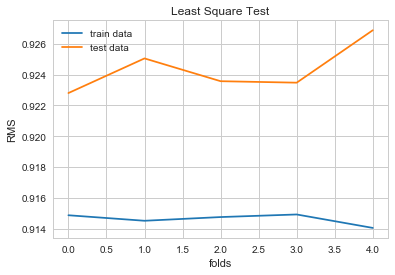

Mean error on Lsq train data:  0.915 with a std on the error of: 0.000
Mean error on Lsq test data:  0.924 with a std on the error of: 0.001


In [10]:
#print and visualize the final conclusion
nice_plot('Global mean',rms_train_global, rms_test_global)
nice_print(rms_train_global,rms_test_global, 'global')

nice_plot('User mean',rms_train_user, rms_test_user)
nice_print(rms_train_user,rms_test_user, 'user')

nice_plot('Item mean',rms_train_item, rms_test_item)
nice_print(rms_train_item,rms_test_item, 'item')

nice_plot('Least Square Test',rms_train_lsq, rms_test_lsq)
nice_print(rms_train_lsq,rms_test_lsq, 'Lsq')

In [11]:
print('The found parameters for the least square fit of the regression line are:')
print('{:17}'.format('------------------------'))
print('{}  {}  {}'.format('alpha', 'beta', 'gamma'))
print('{:05.3f} {:05.3f} {:05.3f}'.format(np.mean(param1), np.mean(param2), np.mean(param3)))

The found parameters for the least square fit of the regression line are:
------------------------
alpha  beta  gamma
0.782 0.875 -2.352


## Interpretation of the results ##

The RMSE shows a decrease as the naive models become more complex. For comparison, we can use the Netflix baseline for their recommandation system. Their RMSE was 0.9514. Although the data sets are different this number still gives an estimate of a proper RMSE. Only the linear combination is below the Netflix baseline. 

 - HERE I WILL ADD ALL MODELS ON ONE GRAPH FOR COMPARISON -- TO SEE HOW THE RMSE DECREASES AS MODEL COMPLEXITY INCREASES
 - also i will try to remove the decimals from the x-axis from the graphs with the folds :') 

The information we used to train the model was very global. If we used more specific information gathered form the train data set we expect the deviation between the train and test data to be larger, as the model will be more specific for the data set in which it is trained. The information we used for our recommandation systems were very global. The global models translates to the small deviation between the test and train data, but to a higher RMSE compared to a more advanced recommandation system (see part 2). 

The small deviation between the train and test data sets are clearly visible in the first model. The global mean model is the most global model we used, therefore the test data and train data overlap and even have the same RMSE. The small standard deviations corresponds to a stable model. Again this is due to the global information we used to train the model. If more specific information was used while determining the model, we would expect the standard deviation to increase. 